In [55]:
## scRNA- Seq analysis with ScanPy

In [56]:
# Import Libraries

import os
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [57]:
# Set verbosity and figure parameters

sc.settings.verbosity = 3

sc.settings.set_figure_params(dpi=80, facecolor='white')

In [58]:
# # Path to the 10X Genomics H5 file

h5_file = os.path.expanduser("~/Desktop/Multi-omics_Project/Multiome/filtered_feature_bc_matrix.h5")

In [59]:
# 1. Load the data from the 10X H5 file

adata = sc.read_10x_h5(h5_file)

# Ensure gene names are unique

adata.var_names_make_unique()

reading /Users/prasanthkumar/Desktop/Multi-omics_Project/Multiome/filtered_feature_bc_matrix.h5
 (0:00:03)


In [60]:
print(adata)

AnnData object with n_obs × n_vars = 18179 × 38592
    var: 'gene_ids', 'feature_types', 'genome', 'interval'


In [61]:
# 2. Calculate QC metrics

# Total counts per cell (n_counts) and number of genes per cell (n_genes)

if hasattr(adata.X, 'A1'):
    adata.obs['n_counts'] = adata.X.sum(axis=1).A1
    adata.obs['n_genes'] = (adata.X > 0).sum(axis=1).A1
else:
    adata.obs['n_counts'] = np.sum(adata.X, axis=1)
    adata.obs['n_genes'] = np.sum(adata.X > 0, axis=1)

In [62]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')

In [63]:
if hasattr(adata[:, adata.var['mt']].X, 'A1'):
    adata.obs['percent_mt'] = (adata[:, adata.var['mt']].X.sum(axis=1).A1 / adata.obs['n_counts']) * 100
else:
    adata.obs['percent_mt'] = (np.array(np.sum(adata[:, adata.var['mt']].X, axis=1)).flatten() / adata.obs['n_counts']) * 100

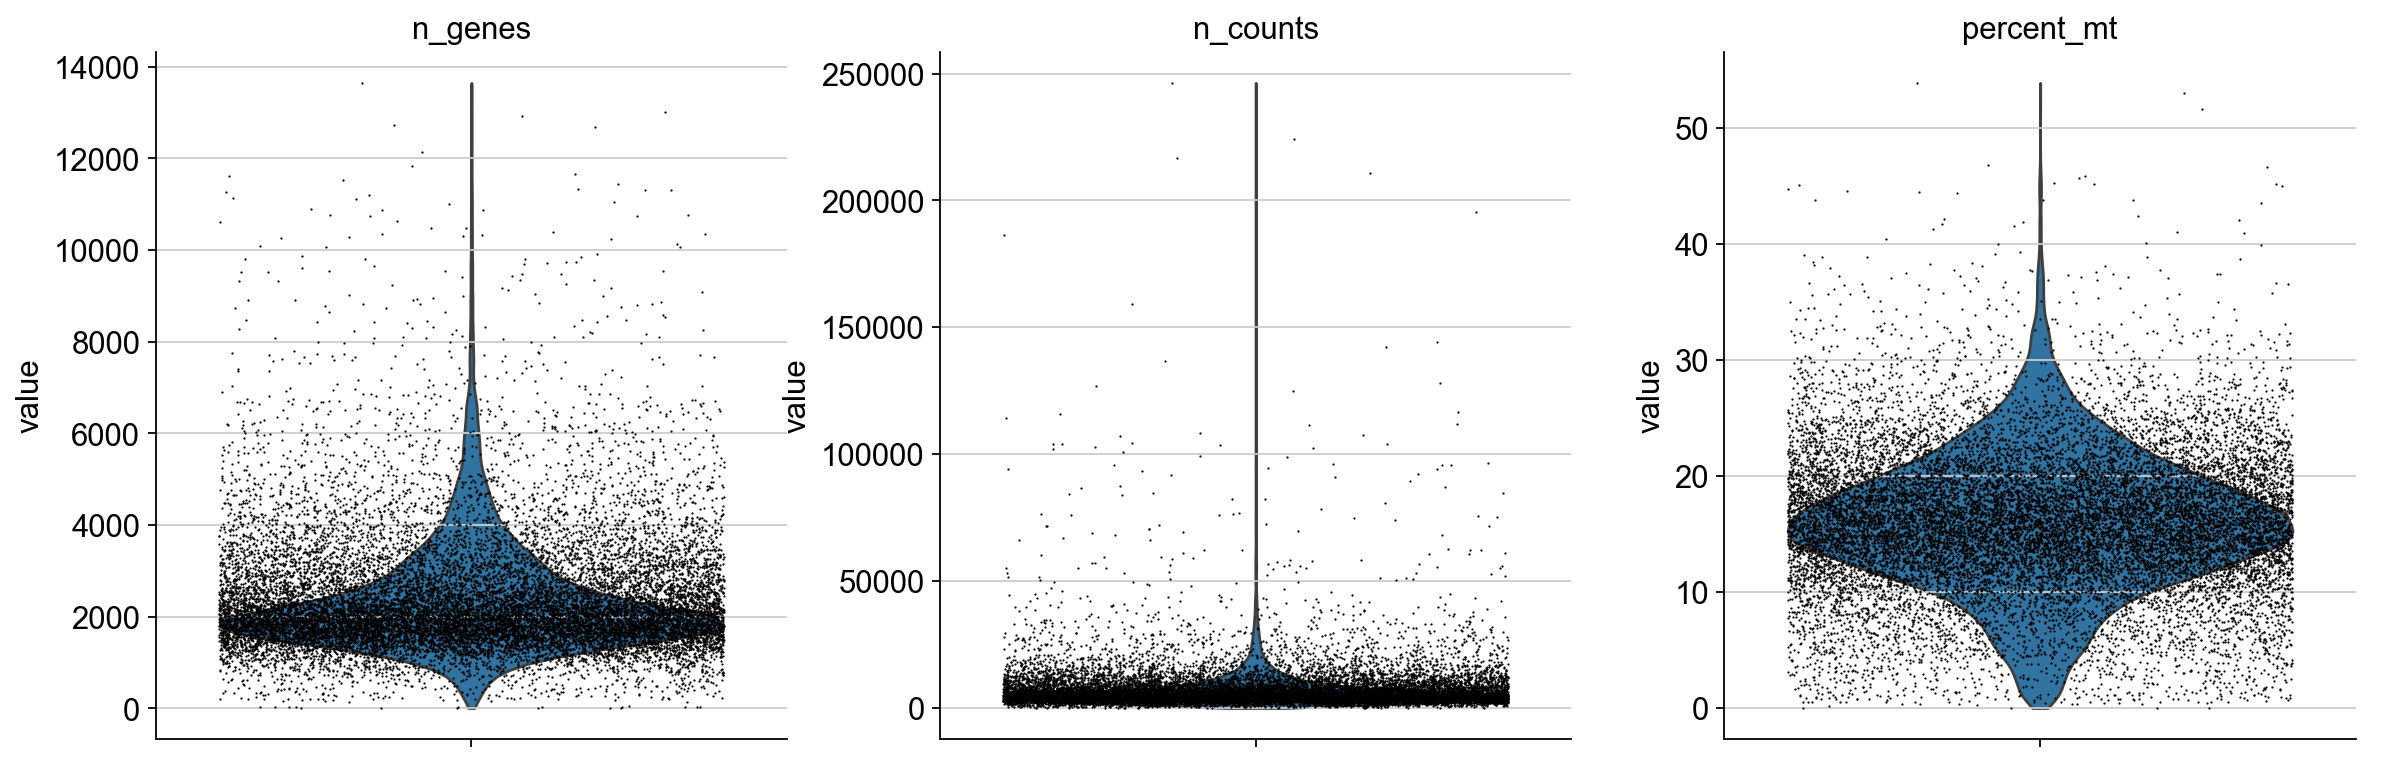

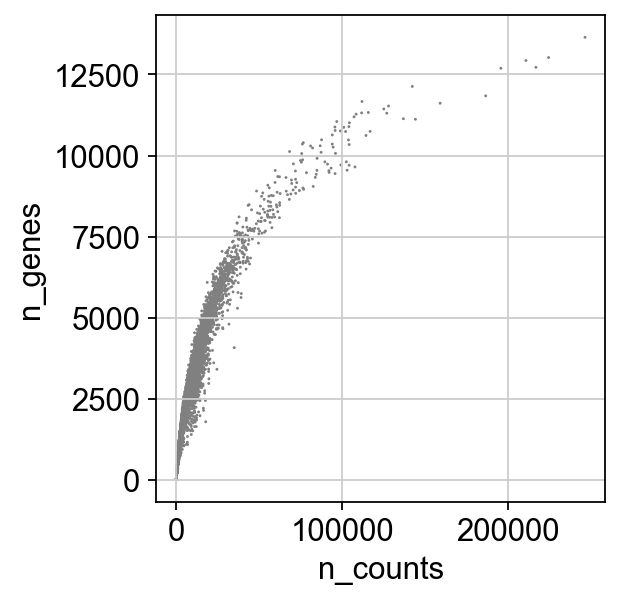

In [64]:
# 3. Visualize QC metrics

sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mt'], jitter=0.4, multi_panel=True)

sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [65]:
# 4. Filter cells based on QC thresholds

# Keep cells with min_genes > 200, max_genes < 6000, and percent_mt < 15

sc.pp.filter_cells(adata, min_genes=200)

adata = adata[adata.obs['n_genes'] < 6000, :]

adata = adata[adata.obs['percent_mt'] < 15, :]

filtered out 33 cells that have less than 200 genes expressed


In [66]:
print("After filtering:")

print(adata)

After filtering:
View of AnnData object with n_obs × n_vars = 7767 × 38592
    obs: 'n_counts', 'n_genes', 'percent_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'mt'


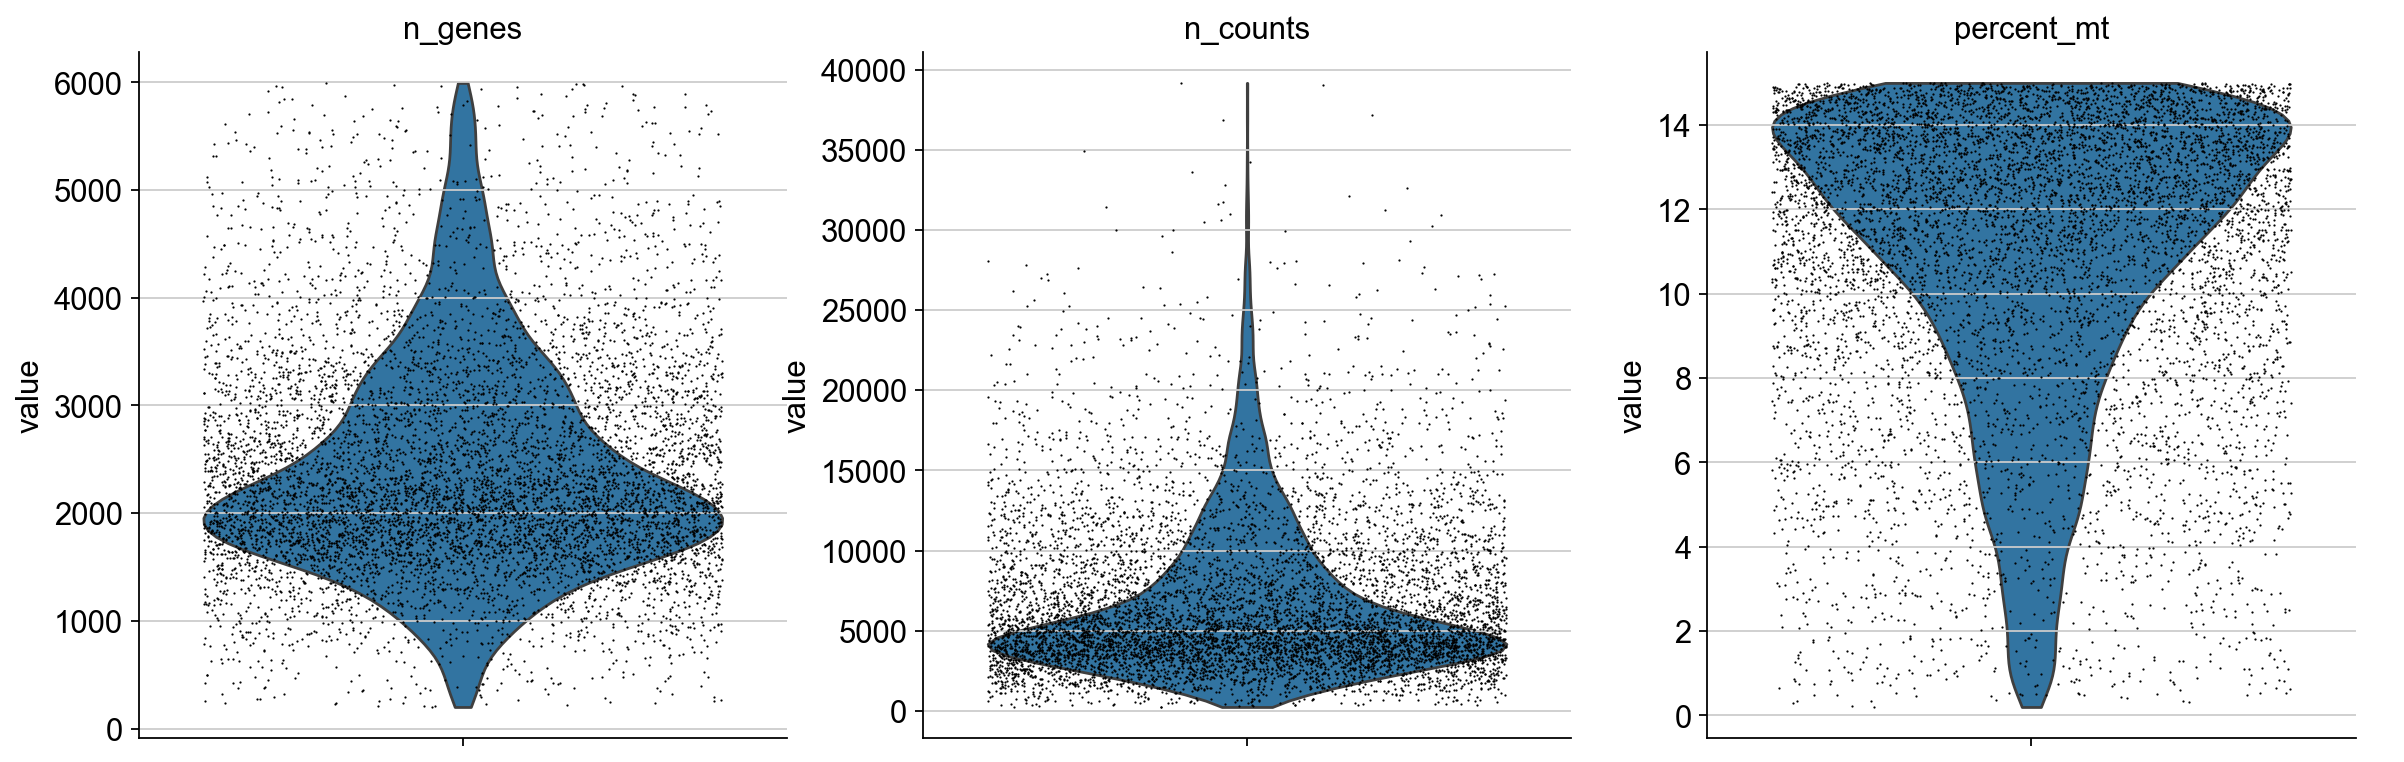

In [67]:
# Plot violin plots for 'n_genes', 'n_counts', and 'percent_mt' after Quality_Filtering

sc.pl.violin(
    adata, 
    keys=['n_genes', 'n_counts', 'percent_mt'], 
    jitter=0.4,         
    multi_panel=True  
)

In [68]:
# 5. Normalize and log-transform the data

sc.pp.normalize_total(adata, target_sum=1e4)

sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)


In [69]:
# 6. Identify highly variable genes (HVGs)

# Using the Seurat v3 flavor to select 4000 top variable genes

sc.pp.highly_variable_genes(adata, flavor='seurat_v3', n_top_genes=4000)

# Subset the data to include only HVGs

adata = adata[:, adata.var['highly_variable']]

extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


In [70]:
# 7. Scale the data

sc.pp.scale(adata, max_value=None) 

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [71]:
# Run PCA to reduce the Dimensionality

sc.tl.pca(adata, svd_solver='arpack', n_comps=30)


variance_ratio = adata.uns['pca']['variance_ratio']

computing PCA
    with n_comps=30
    finished (0:00:00)


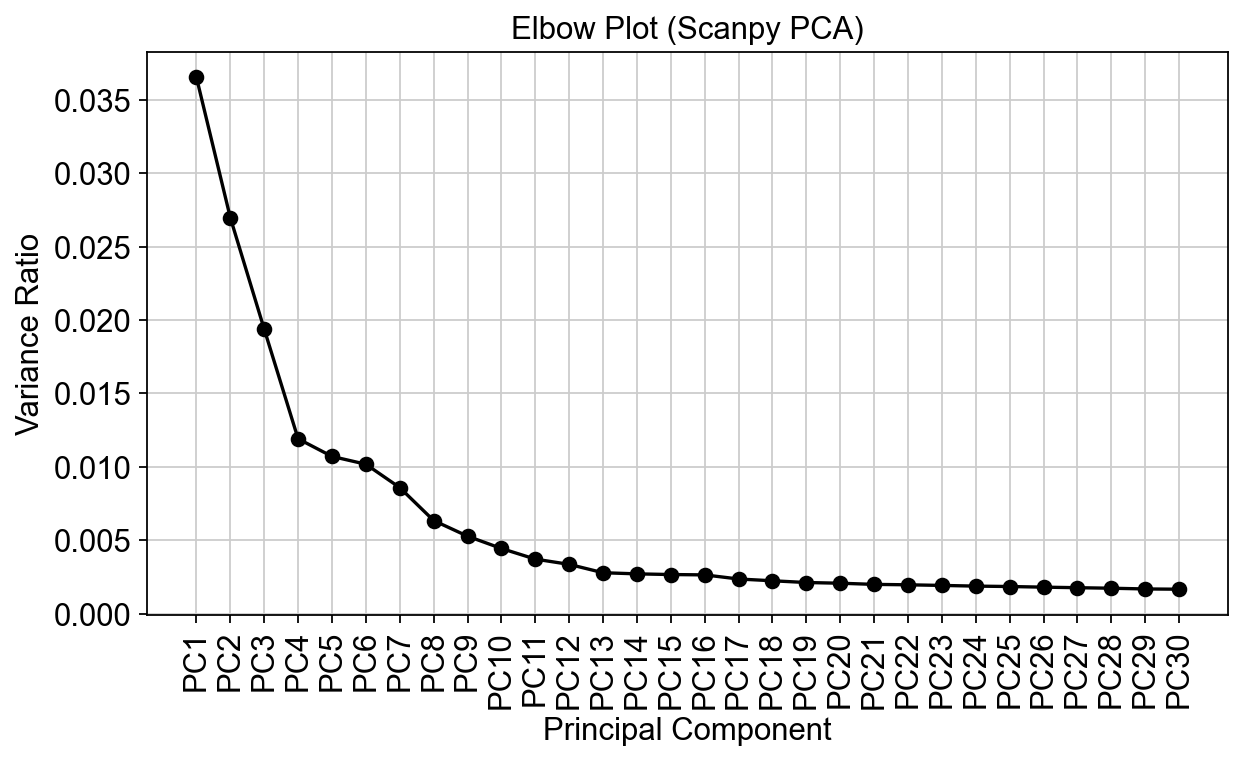

In [72]:
# Create an array of principal component indices

x = np.arange(1, len(variance_ratio) + 1)

# Figure Size
plt.figure(figsize=(8, 5))

# 
plt.plot(x, variance_ratio, marker='o', linestyle='-', color='black')

# Label each PC on the x-axis
plt.xticks(x, [f"PC{i}" for i in x], rotation=90)

# Title and Labels of the plot
plt.title("Elbow Plot (Scanpy PCA)")
plt.xlabel("Principal Component")
plt.ylabel("Variance Ratio")


plt.tight_layout()

# Show the plot
plt.show()

In [73]:
# 9. Build the neighbor graph and perform clustering

# Using 12 PCs to match dims_use = 1:12 from Seurat

n_pcs = 12

sc.pp.neighbors(adata, n_neighbors=30, n_pcs=n_pcs)

computing neighbors
    using 'X_pca' with n_pcs = 12
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [74]:
# Use the Leiden algorithm with a resolution of 1.0 (comparable to Seurat's FindClusters)
sc.tl.leiden(adata, resolution=1.0, random_state=42)

running Leiden clustering
    finished: found 24 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:02)


computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:06)


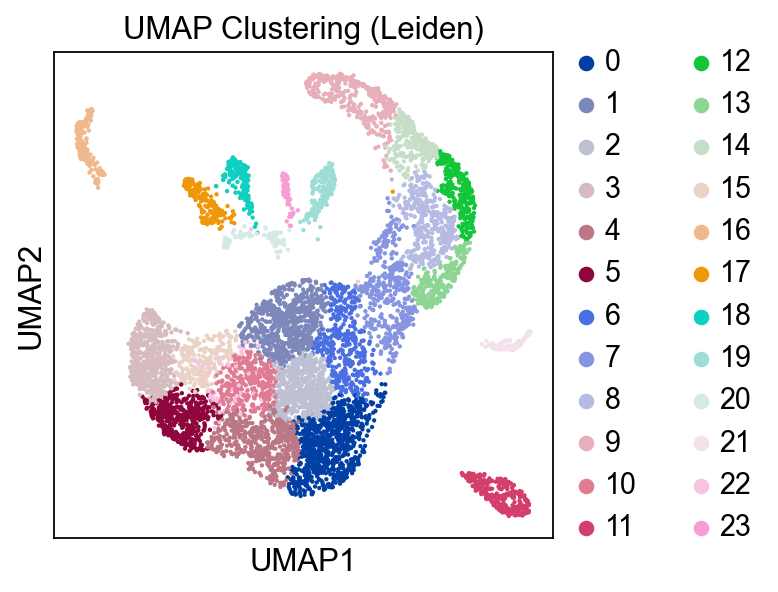

In [75]:
# 10. Compute UMAP for visualization

sc.tl.umap(adata)

sc.pl.umap(adata, color=['leiden'], title="UMAP Clustering (Leiden)")

In [76]:
sc.tl.rank_genes_groups(adata, groupby='leiden', method='wilcoxon')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


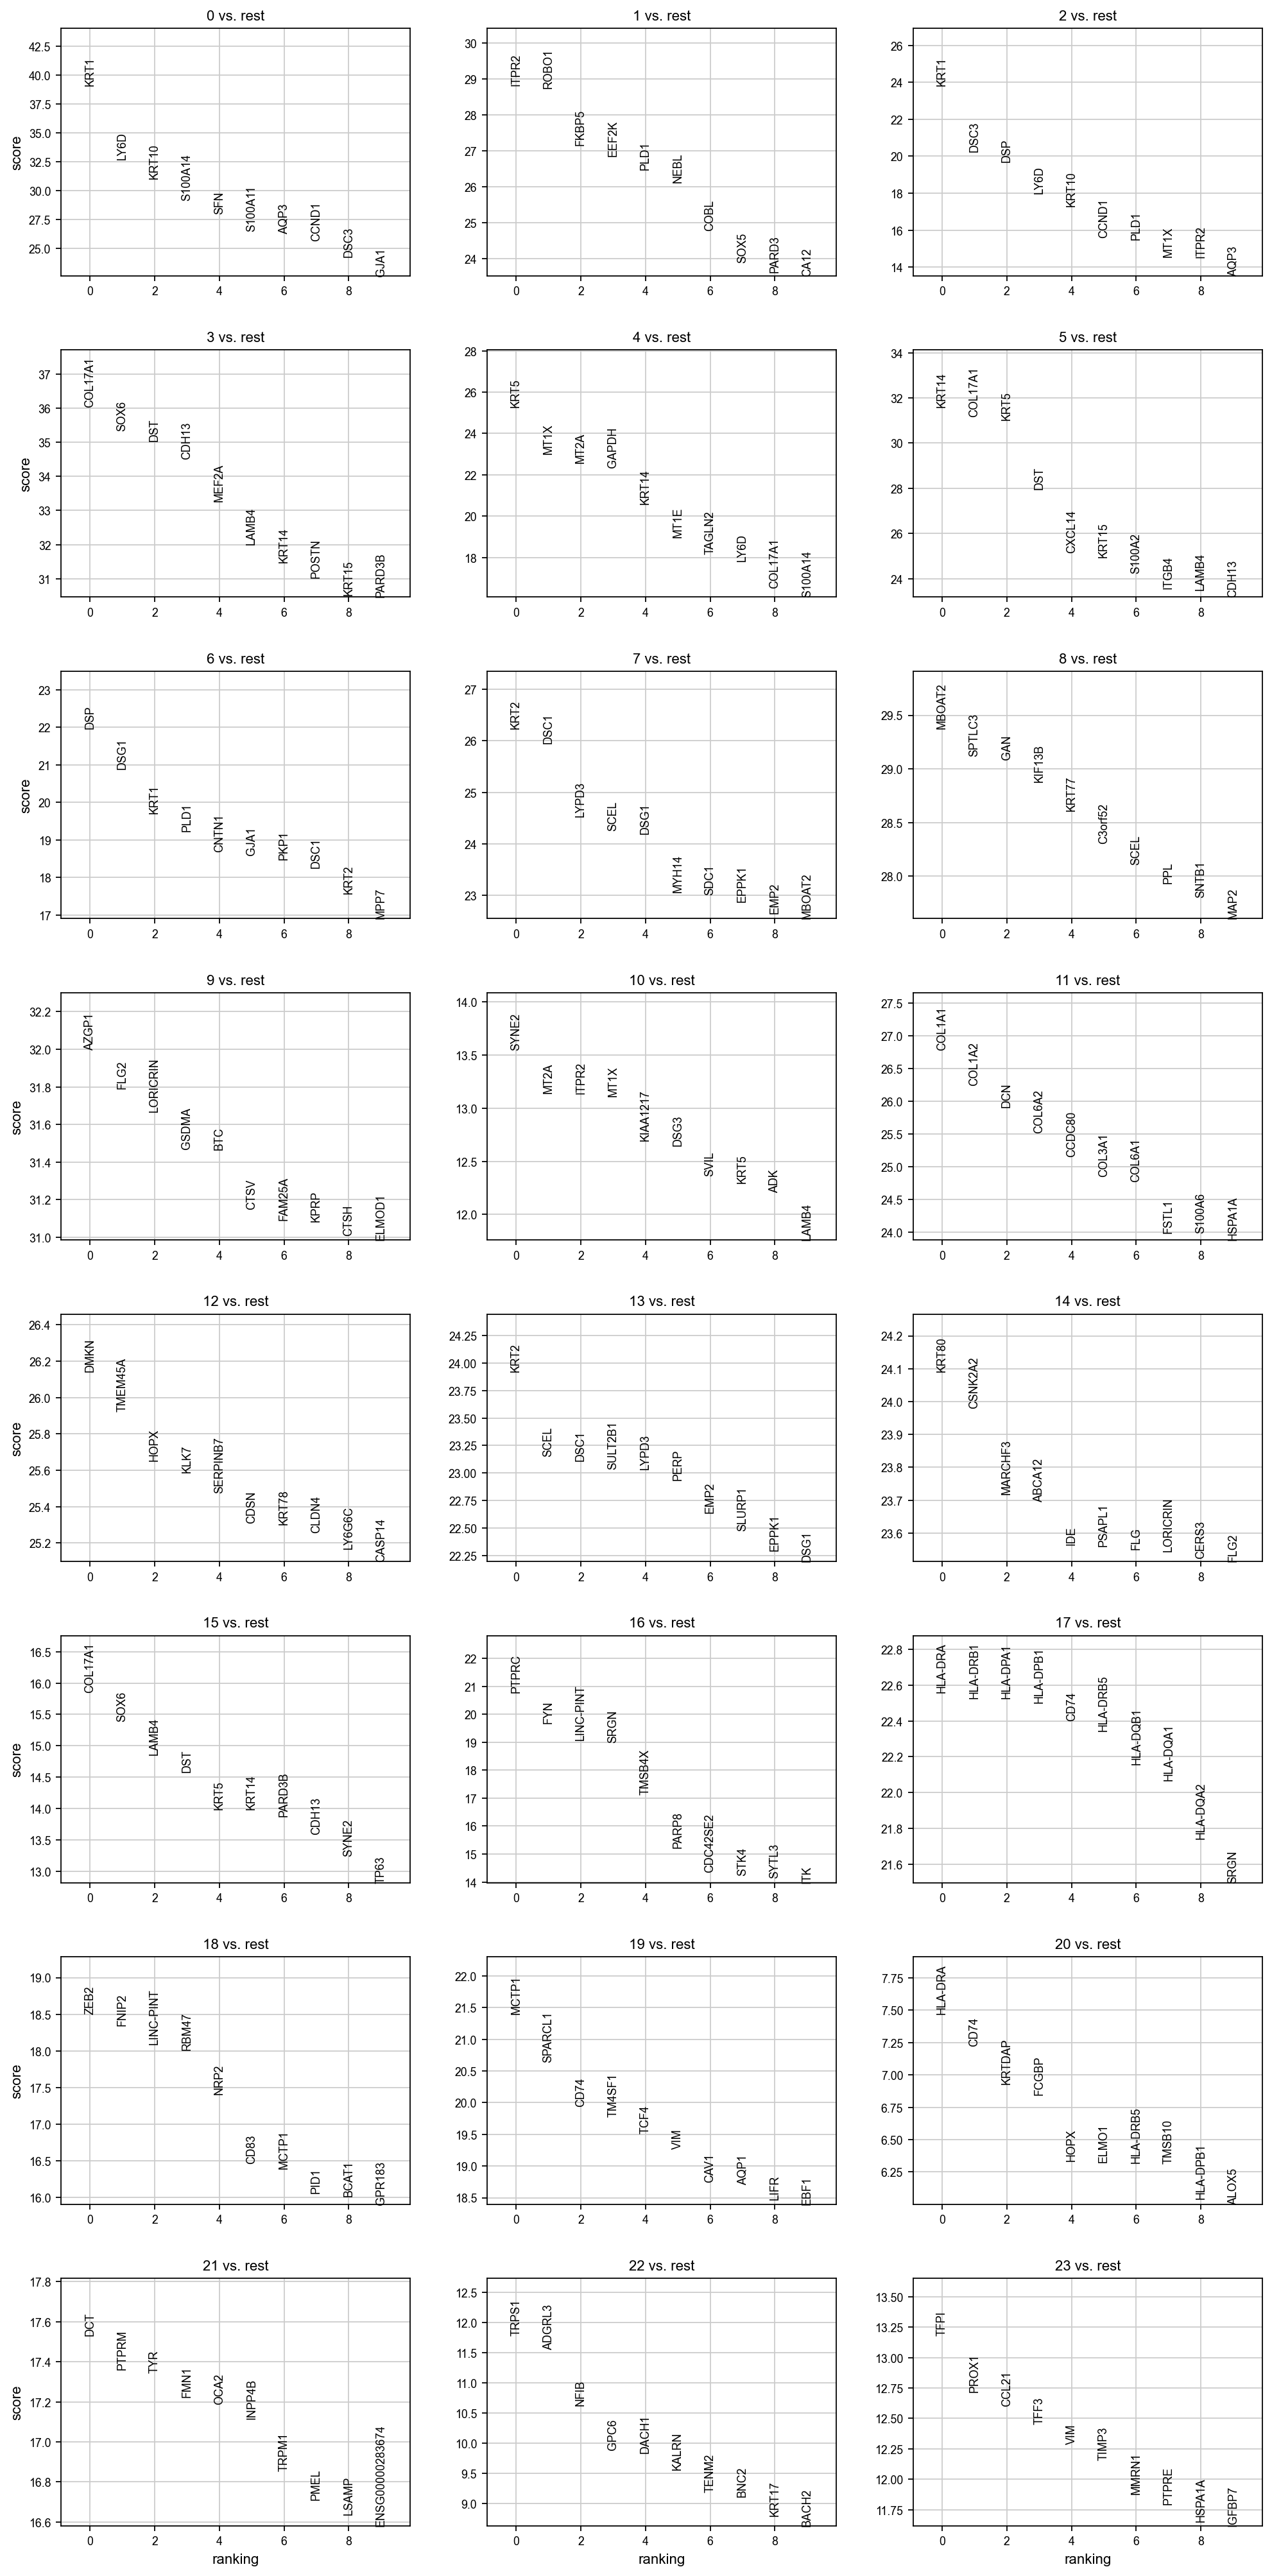

In [77]:
# Matplotlib rcParams
mpl.rcParams['figure.figsize'] = (5, 4)
mpl.rcParams['axes.titlesize'] = 10
mpl.rcParams['axes.labelsize'] = 10
mpl.rcParams['xtick.labelsize'] = 8
mpl.rcParams['ytick.labelsize'] = 8


# Plot the top 10 marker genes per cluster in a multi-panel figure.
sc.pl.rank_genes_groups(
    adata,
    n_genes=10,
    sharey=False,
    ncols=3,              
    show=True,
    dpi=100,
)


    using 'X_pca' with n_pcs = 30
Storing dendrogram info using `.uns['dendrogram_leiden']`


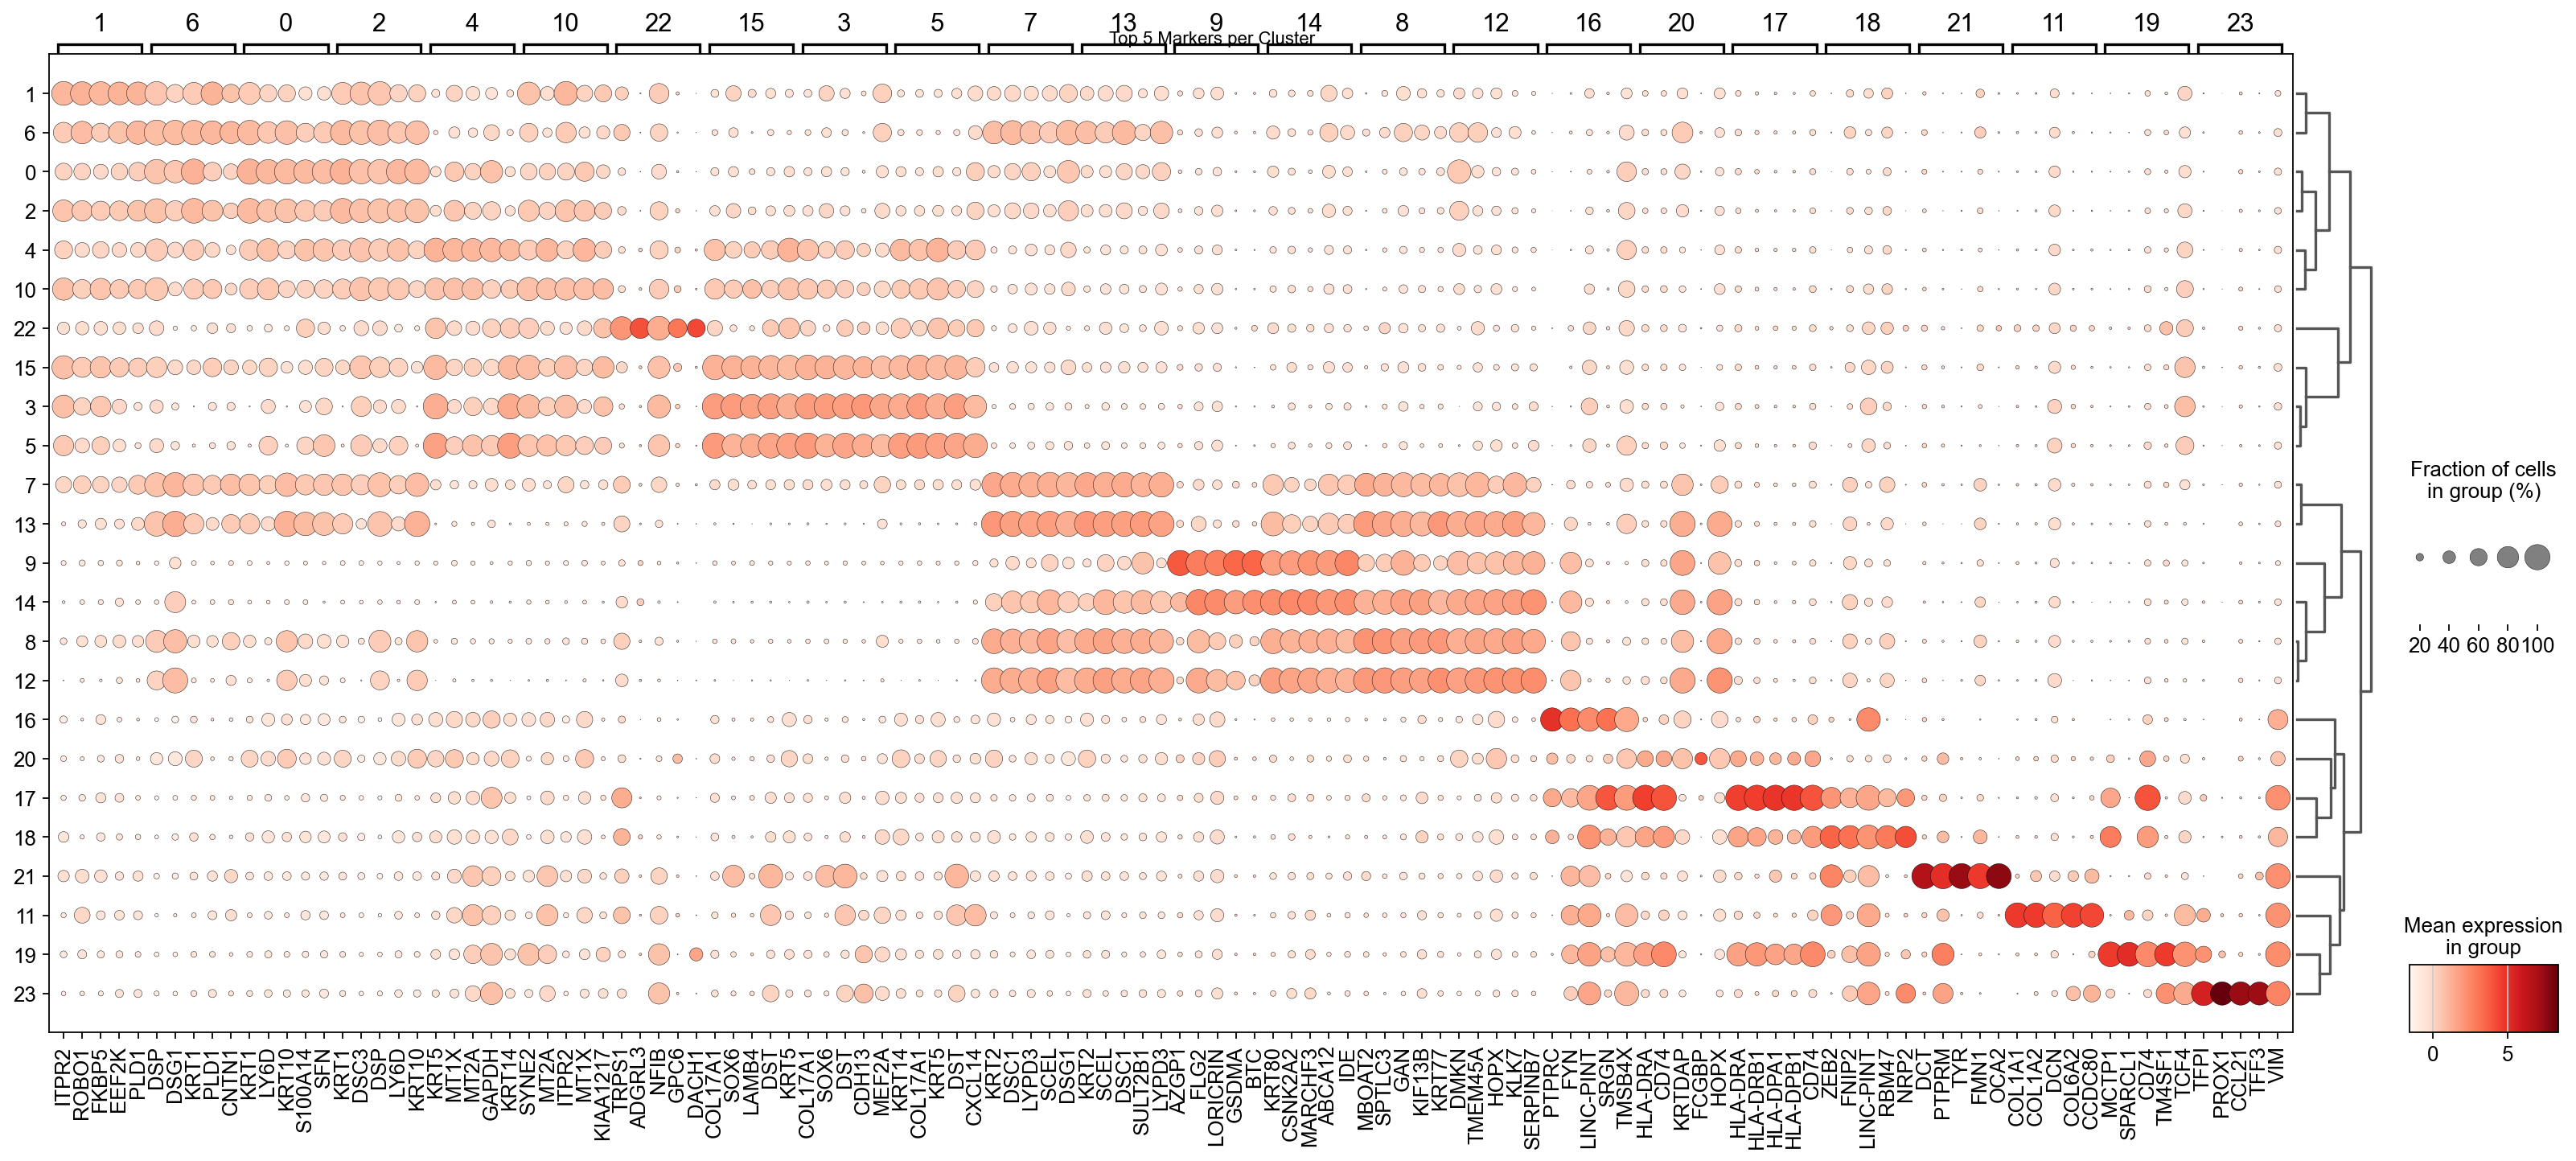

In [78]:
# 12. Create a dot plot for the top 5 marker genes per cluster

sc.pl.rank_genes_groups_dotplot(adata, n_genes=5, title="Top 5 Markers per Cluster", figsize=(25,10))

In [39]:
# Save the processed RNA-seq AnnData object (from Scanpy)
#adata.write("processed_rna_scanpy.h5ad")